In [1]:
import sys
sys.path.insert(0, '/home/NETID/lundvm/code/CorticalCultureAnalysis')
from utils import extract_sequence, plot_histogram

In [2]:
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_hist(sequence):
    
    max_count = np.max(sequence)
    sequence = sequence.transpose()
    timesteps = sequence.shape[0]
    
    hist3d = np.zeros((timesteps, max_count))
    for i in range(timesteps):
        hist, __ = np.histogram(sequence[i], bins=np.arange(max_count+1))
        hist3d[i, 0:max_count] = hist
    
    return hist3d

In [66]:
def set_axes(ax, seq_type, duration, into_burst, offset, step):
    
    ax.set_xlabel('spike count', fontsize=14)
    ax.set_ylabel('time step', fontsize=14)
    if seq_type==0:
        ax.set_yticklabels(labels=np.arange(-(into_burst)+offset-step, duration+offset, step).astype('str'))
    if seq_type==1:
        ax.set_yticklabels(labels=np.arange(into_burst-duration-offset-step, into_burst-offset, step).astype('str'))

In [55]:
def plot_heatmap_compare(sequence1, sequence2, sequence3, seq_type, cmap='jet'):
   
    hist3d1 = get_hist(sequence1)
    hist3d2 = get_hist(sequence2)
    hist3d3 = get_hist(sequence3)
    
    combined_data = np.concatenate((hist3d1,hist3d2, hist3d3), axis=1)    
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(131)
    set_axes(ax1, seq_type, duration=50, into_burst=0, offset=200, step=10)
    ax1.imshow(hist3d1, cmap=cmap, vmin = _min, vmax = _max)
    
    ax2 = fig.add_subplot(132)
    set_axes(ax2, seq_type, duration=50, into_burst=0, offset=0, step=10)
    ax2.imshow(hist3d2, cmap=cmap, vmin = _min, vmax = _max)
    
    ax3 = fig.add_subplot(133)
    set_axes(ax3, seq_type, duration=50, into_burst=50, offset=0, step=10)
    im3 = ax3.imshow(hist3d3, cmap=cmap, vmin = _min, vmax = _max)
    
    plt.tight_layout()
    plt.colorbar(im3, ax=ax3)
    plt.show()

In [5]:
# load spike data
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    spikes = pd.read_csv('/home/NETID/lundvm/data/spikes.csv')
# load burst data
num_timesteps = 600000000 #known from the settings of the simulation
time_steps = np.arange(num_timesteps)
spike_count = np.vstack((time_steps, np.append(np.bincount(spikes['time_step'].values), np.array([0]))))
num_spikes = spike_count.shape[1]

In [6]:
# load burst data
bursts = pd.read_csv('/home/NETID/lundvm/data/allAvalBurst.csv')
burst_start_mask = np.in1d(spike_count[0], bursts['StartT'].values)
num_bursts = bursts['StartT'].values.shape[0]

In [7]:
# extract 50-timestep sequences right before bursts
preburst_50a = extract_sequence(spike_count, num_bursts, burst_start_mask, 50, 1)
# extract 50-timestep sequences at the beginning of bursts (first 50 timesteps of bursts)
preburst_50b = extract_sequence(spike_count, num_bursts, burst_start_mask, 0, 1, into_burst=50)
# extract 50-timestep sequences 200 timesteps before bursts (gap=200 timesteps)
preburst_50c = extract_sequence(spike_count, num_bursts, burst_start_mask, 50, 1, offset=200)

100%|██████████| 600000000/600000000 [02:08<00:00, 4681391.23it/s]


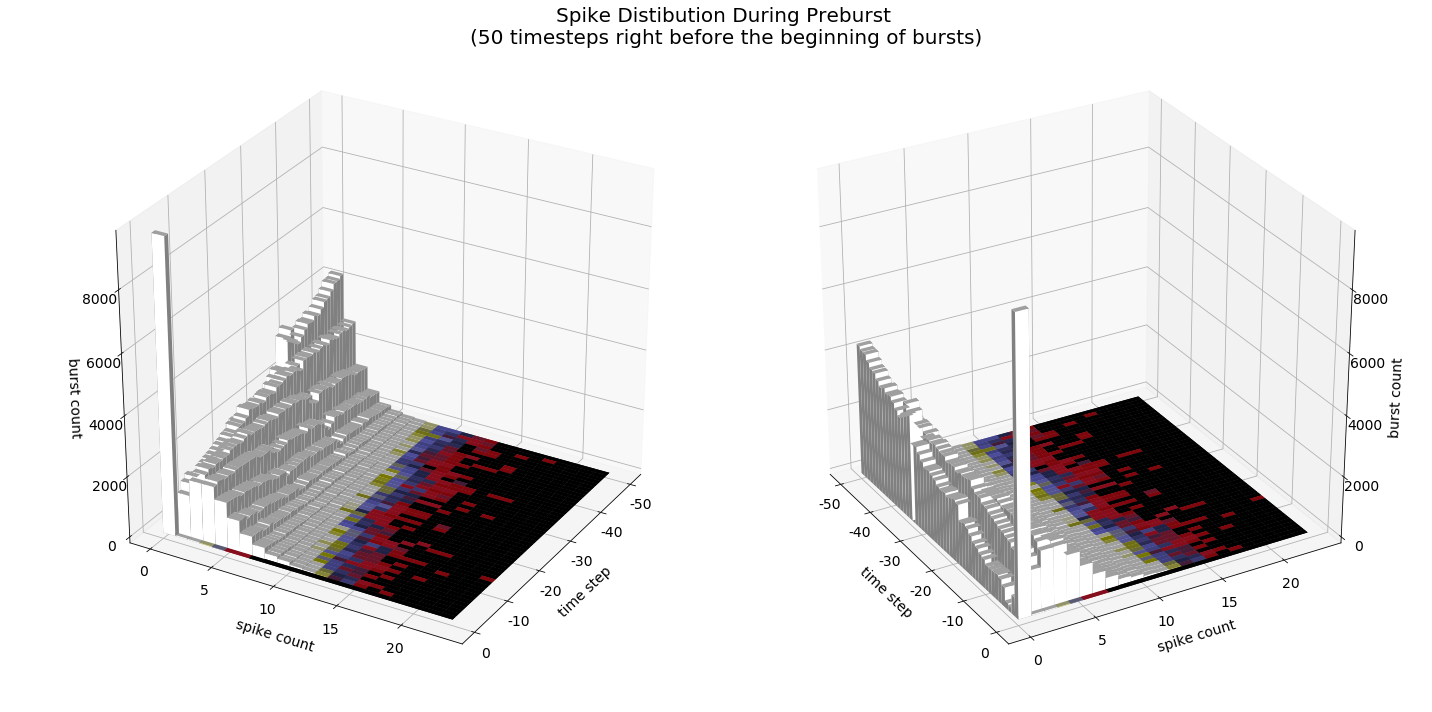

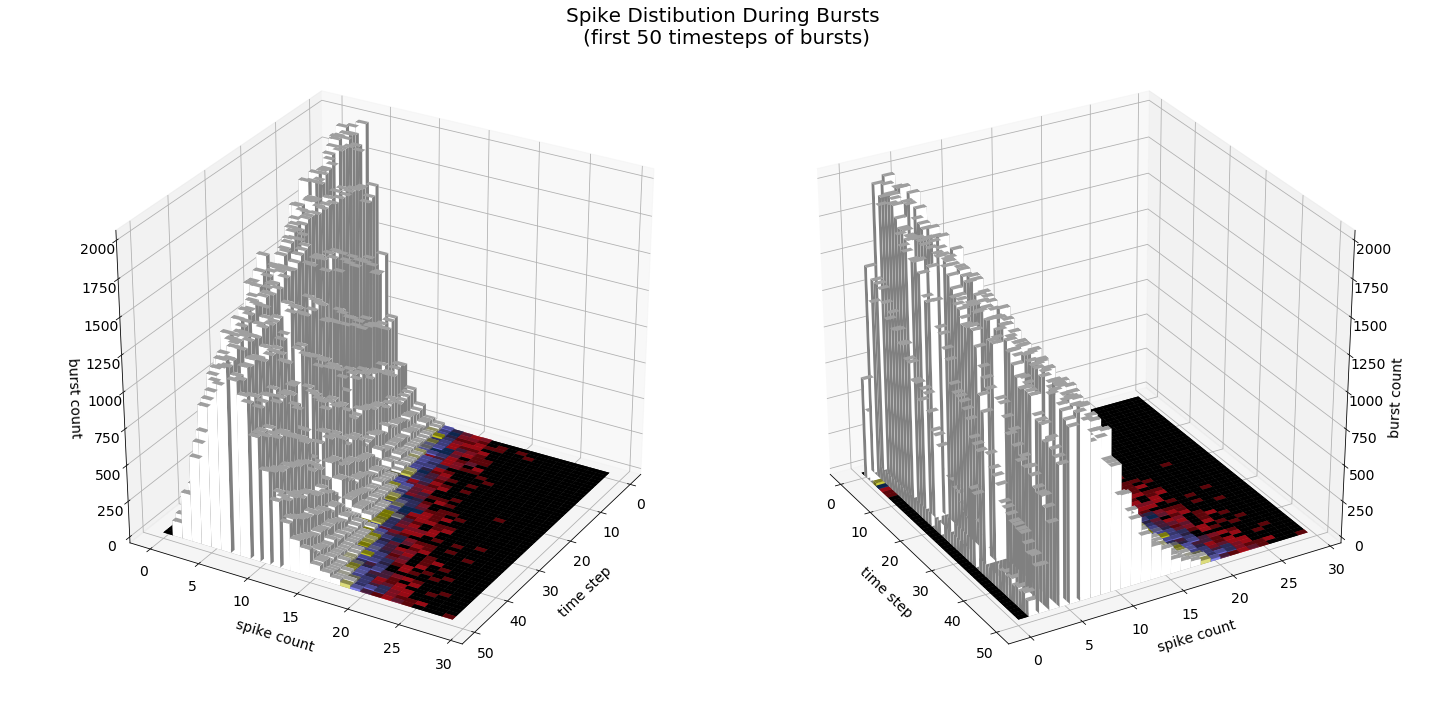

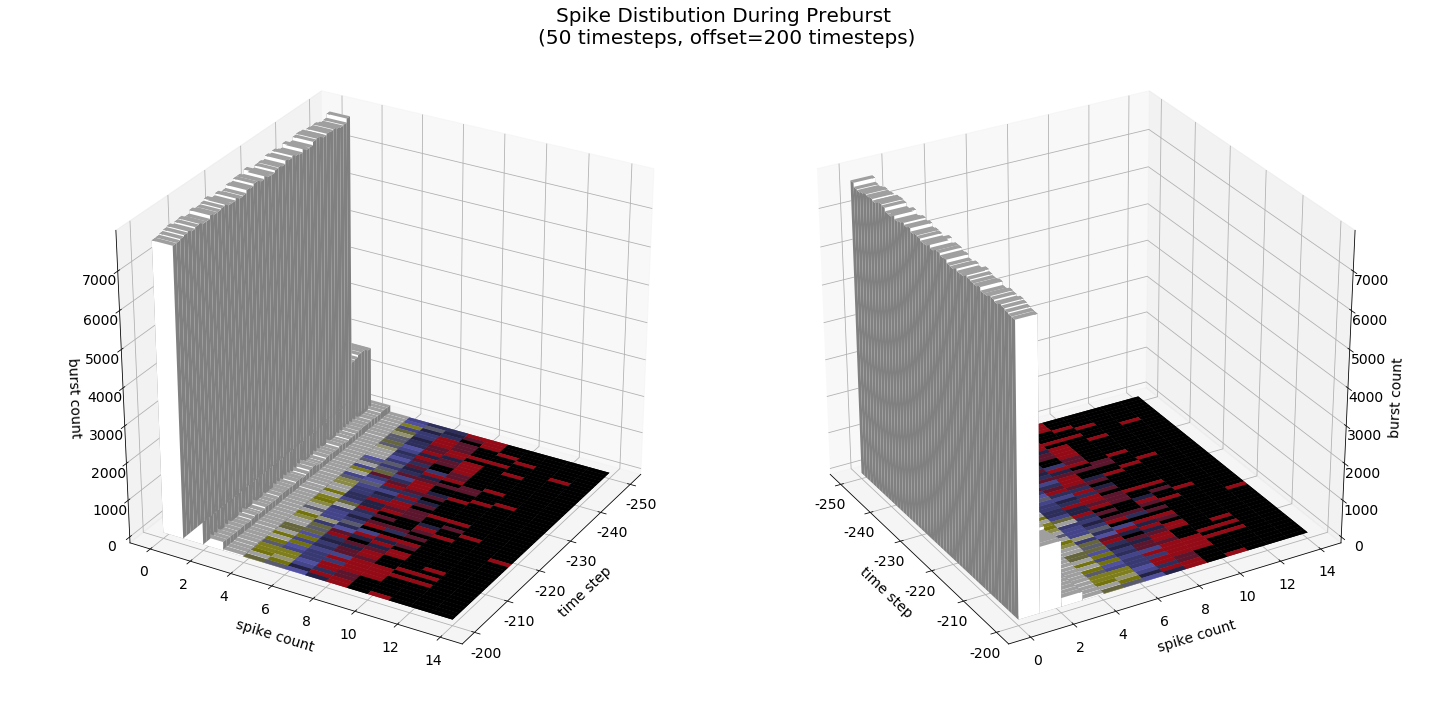

In [79]:
plot_histogram(preburst_50a, (20, 10), 
               'Spike Distibution During Preburst \n(50 timesteps right before the beginning of bursts)', 
               seq_type=1, step=10, duration=50, colormap='gist_stern')
plot_histogram(preburst_50b, (20, 10), 'Spike Distibution During Bursts \n(first 50 timesteps of bursts)', 
               seq_type=1, step=10, duration=50, colormap='gist_stern', into_burst=50)
plot_histogram(preburst_50c, (20, 10), 'Spike Distibution During Preburst \n(50 timesteps, offset=200 timesteps)', 
               seq_type=1, step=10, duration=50, colormap='gist_stern', offset=200)

These heatmaps are flattened versions of the histograms above.
From left to right, the first plot is a histogram of spiking activity during preburst (offset=200 timesteps);
The second plot is a histogram of spiking activity right before the beginning of bursts;
The third plot is a histogram of spiking activity during the first 50 timesteps of bursts.


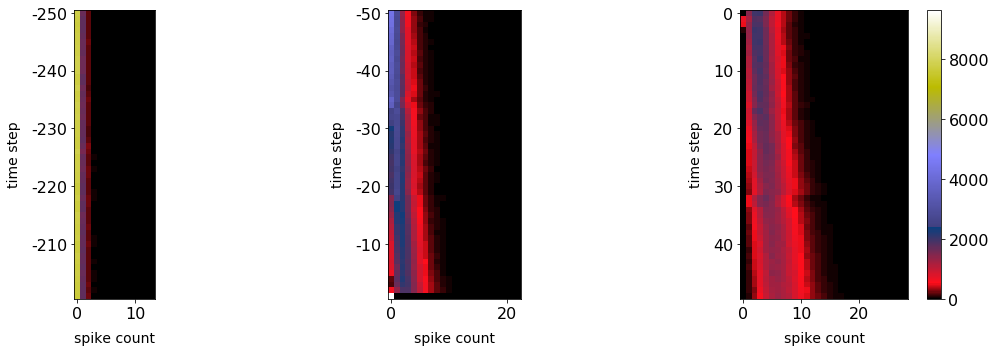

In [82]:
print('These heatmaps are flattened versions of the histograms above.')
print('From left to right, the first plot is a histogram of spiking activity during preburst (offset=200 timesteps);')
print('The second plot is a histogram of spiking activity right before the beginning of bursts;')
print('The third plot is a histogram of spiking activity during the first 50 timesteps of bursts.')
plot_heatmap_compare(preburst_50c, preburst_50a, preburst_50b, 1, cmap='gist_stern')

In [57]:
preburst_300 = extract_sequence(spike_count, num_bursts, burst_start_mask, 250, 1, into_burst=50)

100%|██████████| 600000000/600000000 [02:19<00:00, 4288631.86it/s]


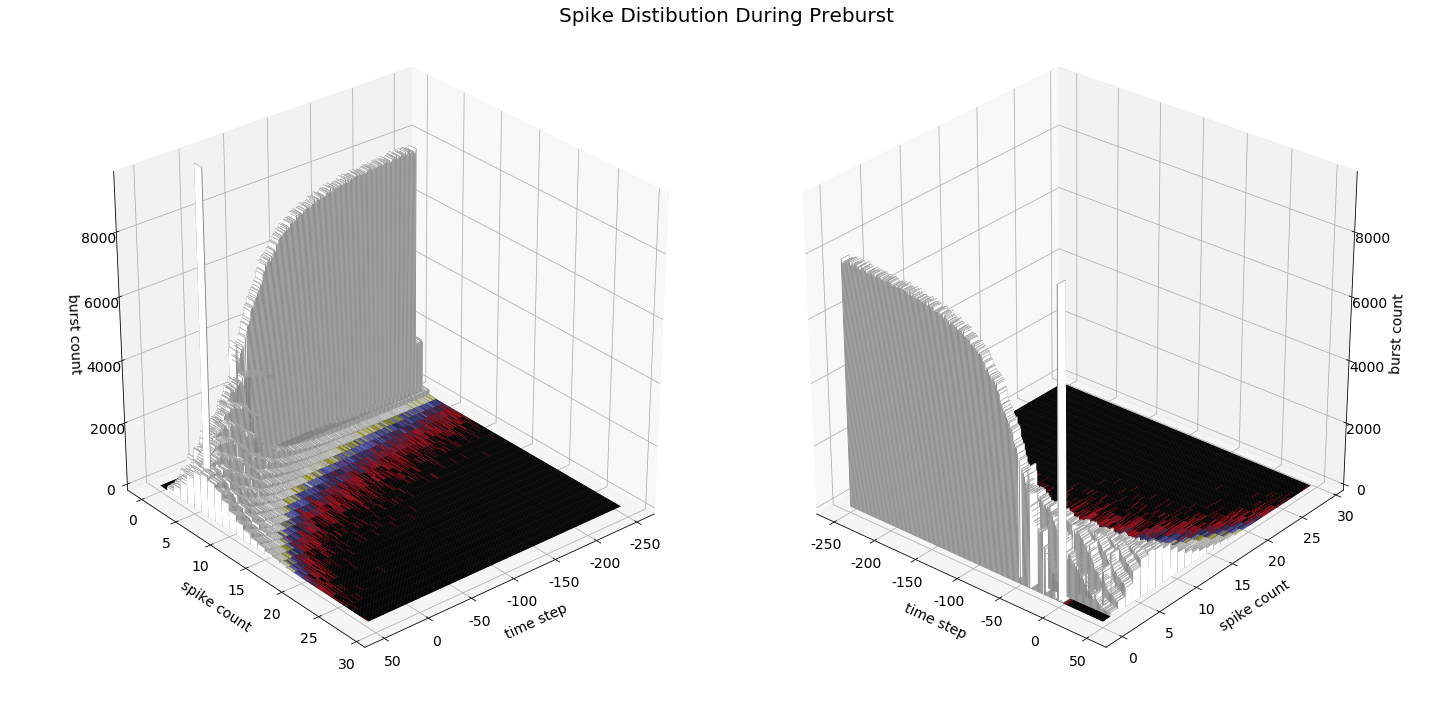

Sequence duration = 300 timesteps (250 timesteps during preburst, 50 timesteps during burst).
0 on the time step scale indicates the end of preburst.


In [83]:
plot_histogram(preburst_300, (20, 10), 'Spike Distibution During Preburst', seq_type=1, step=50, 
               duration=300, angle=50, colormap='gist_stern', into_burst=50)
print('Sequence duration = 300 timesteps (250 timesteps during preburst, 50 timesteps during burst).')
print('0 on the time step scale indicates the end of preburst.')

In [61]:
bursts['IBI'] = bursts['IBI'].shift(-1)
bursts.dropna(inplace=True)
bursts['IBI'] = bursts['IBI'].astype('int32')
burst_end_mask = np.in1d(spike_count[0], bursts['EndT'].values)
num_bursts = bursts['EndT'].values.shape[0]

In [62]:
postburst_50a = extract_sequence(spike_count, num_bursts, burst_end_mask, 50, 0)
postburst_50b = extract_sequence(spike_count, num_bursts, burst_end_mask, 0, 0, into_burst=50)
postburst_50c = extract_sequence(spike_count, num_bursts, burst_end_mask, 50, 0, offset=300)

100%|██████████| 600000000/600000000 [02:11<00:00, 4557360.89it/s]


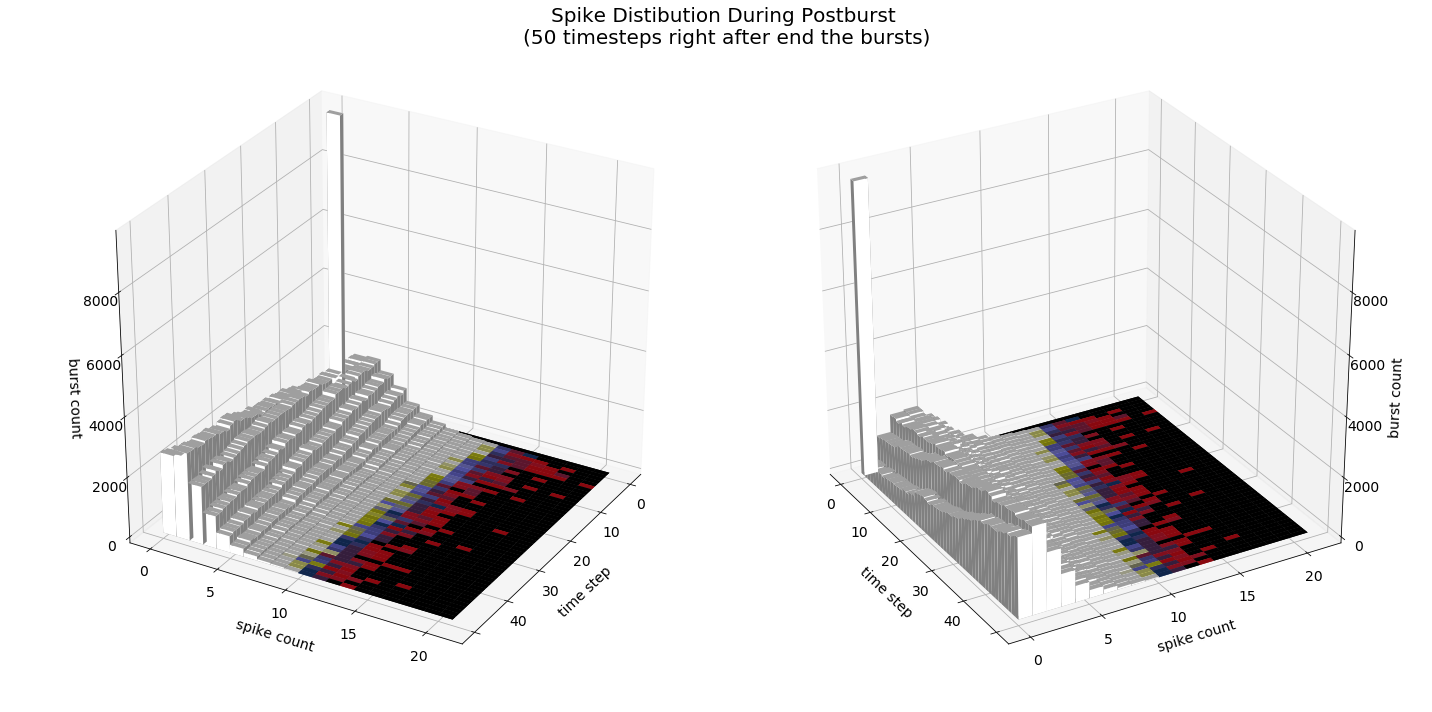

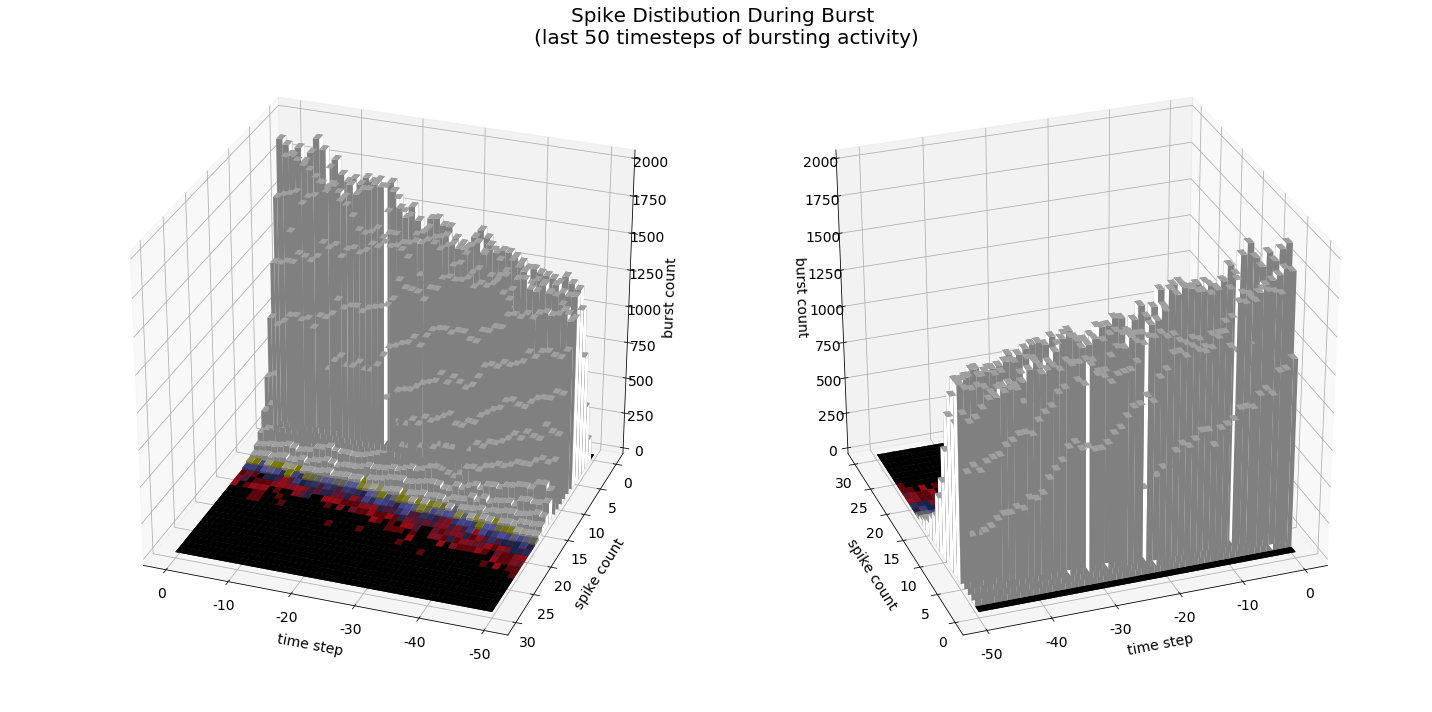

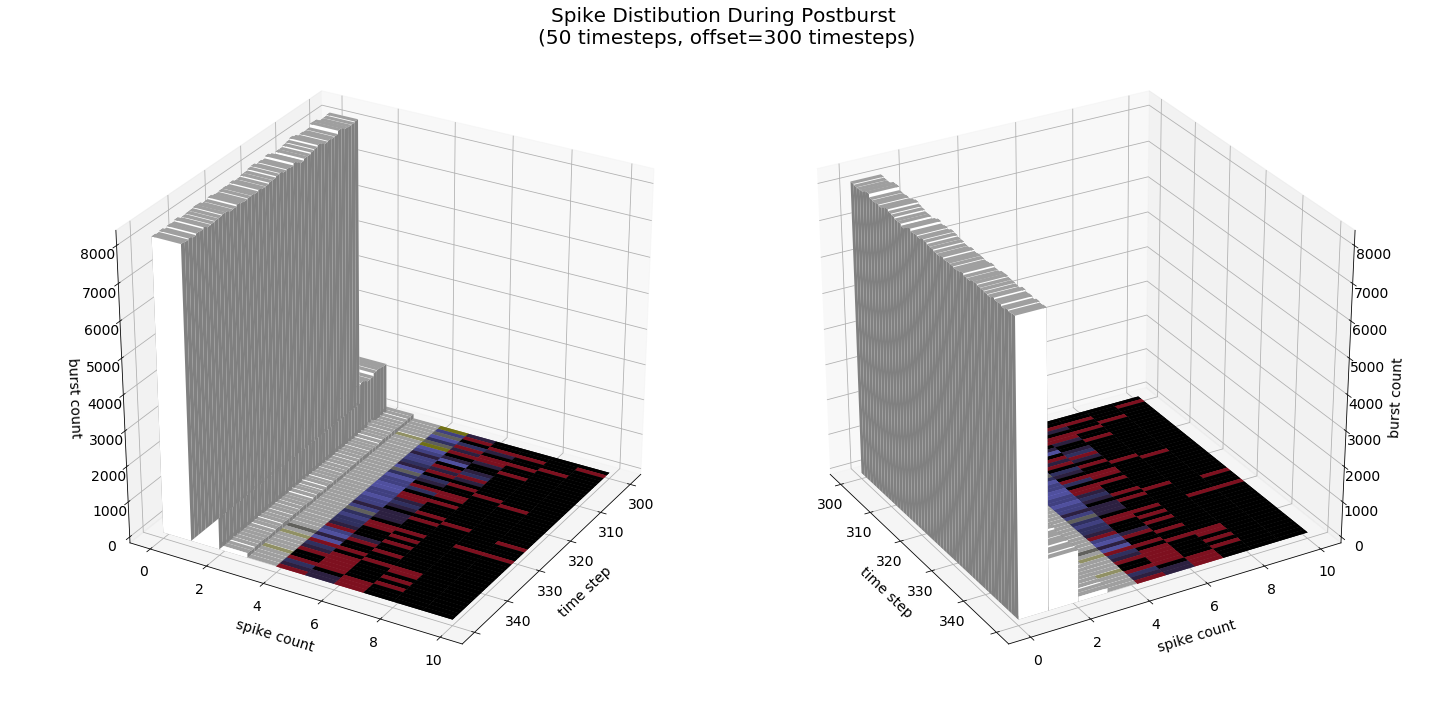

In [84]:
plot_histogram(postburst_50a, (20, 10), 'Spike Distibution During Postburst \n(50 timesteps right after end the bursts)', 
               seq_type=0, step=10, duration=50, colormap='gist_stern')
plot_histogram(postburst_50b, (20, 10), 'Spike Distibution During Burst \n(last 50 timesteps of bursting activity)',
               seq_type=0, step=10, duration=50, angle=110, colormap='gist_stern', into_burst=50)
plot_histogram(postburst_50c, (20, 10), 'Spike Distibution During Postburst \n(50 timesteps, offset=300 timesteps)',
               seq_type=0, step=10, duration=50, colormap='gist_stern', offset=300)

These heatmaps are flattened versions of the histograms above.
From left to right, the first plot is a histogram of spiking activity during postburst (offset=300 timesteps);
The second plot is a histogram of spiking activity right after the end of bursts;
The third plot is a histogram of spiking activity during the last 50 timesteps of bursts.


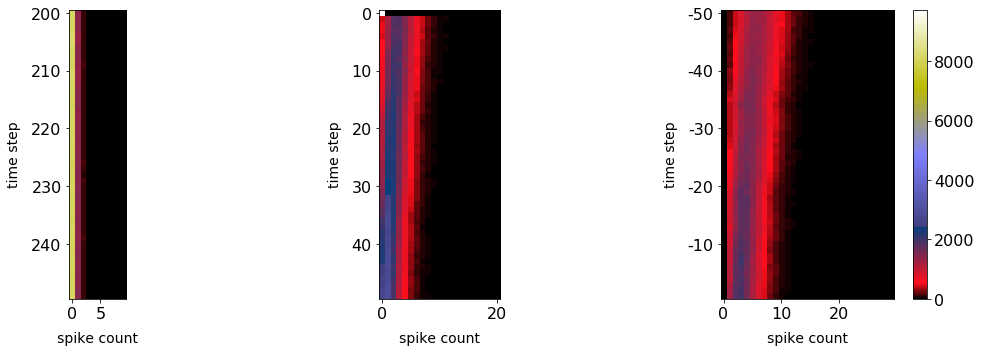

In [85]:
print('These heatmaps are flattened versions of the histograms above.')
print('From left to right, the first plot is a histogram of spiking activity during postburst (offset=300 timesteps);')
print('The second plot is a histogram of spiking activity right after the end of bursts;')
print('The third plot is a histogram of spiking activity during the last 50 timesteps of bursts.')
plot_heatmap_compare(postburst_50c, postburst_50a, postburst_50b, 0, cmap='gist_stern')

In [86]:
postburst_300 = extract_sequence(spike_count, num_bursts, burst_end_mask, 250, 0, into_burst=50)

100%|██████████| 600000000/600000000 [02:15<00:00, 4437779.79it/s]


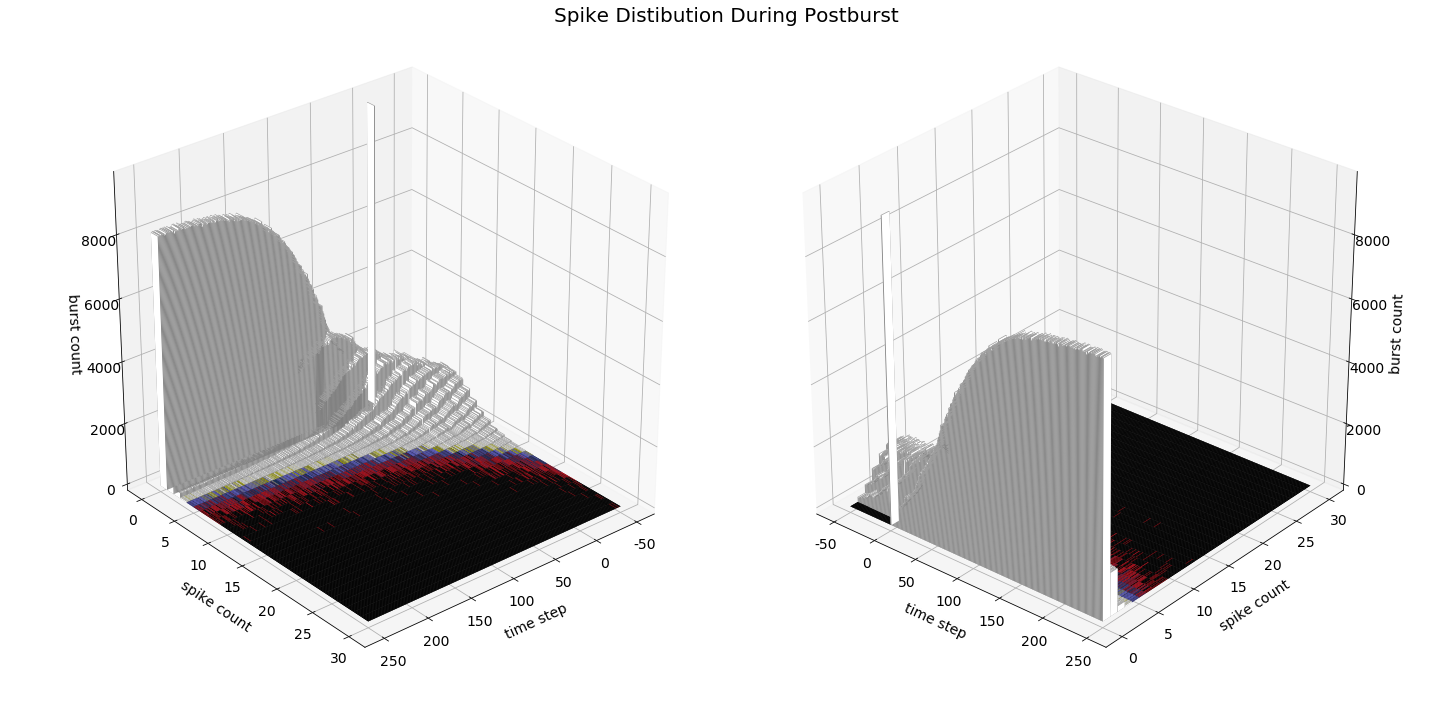

Sequence duration = 300 timesteps (250 timesteps during preburst, 50 timesteps during burst).
0 on the time step scale indicates the start of postburst.


In [88]:
plot_histogram(postburst_300, (20, 10), 'Spike Distibution During Postburst', seq_type=0, step=50, 
               duration=300, angle=50, colormap='gist_stern', into_burst=50)
print('Sequence duration = 300 timesteps (250 timesteps during preburst, 50 timesteps during burst).')
print('0 on the time step scale indicates the start of postburst.')

In [89]:
bursts = bursts[bursts['IBI'] > 10200]
burst_end_mask = np.in1d(spike_count[0], bursts['EndT'].values)
num_bursts = bursts['EndT'].values.shape[0]

In [90]:
postburst_10k = extract_sequence(spike_count, num_bursts, burst_end_mask, 10000, 0, into_burst=0, offset=200)
bins_1000ms = np.add.reduceat(postburst_10k, np.arange(0, postburst_10k.shape[1], 10), axis=1)

100%|██████████| 600000000/600000000 [02:14<00:00, 4452760.92it/s]


In [99]:
data = [go.Heatmap(z=get_hist(bins_1000ms), colorscale='Viridis')]
layout = go.Layout(title='Spike Distribution During Nonburst <br>(duration=1000ms, offset=20ms)', 
                   xaxis=dict(title='spike count'), yaxis=dict(title='ms'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [104]:
data = [go.Heatmap(z=get_hist(postburst_10k), colorscale='Viridis')]
layout = go.Layout(title='Spike Distribution During Nonburst <br>(duration=10k time steps, offset=200 time steps)', 
                   xaxis=dict(title='spike count'), yaxis=dict(title='time step'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)